MNIST Handwritten recognition using Chainer. 

In [0]:
import math
import numpy as np
import chainer
from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import datasets, initializers, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

In [0]:
from chainer.datasets import mnist

train, test = mnist.get_mnist()

In [0]:
pip install cupy


    100% |████████████████████████████████| 2.5MB 9.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/f6/75/a5/0ebbfb438ad45666653b8b527e9432b6771b8c7df1d771b6b5
Successfully built cupy


In [0]:
import chainer
chainer.cuda.available

True

In [0]:
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

In [0]:
class MLP(Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, n_out)

    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = 0  # Set to -1 if you use CPU

model = MLP()
if gpu_id >= 0:
    model.to_gpu(gpu_id)

In [0]:
max_epoch = 10

# Wrap your model by Classifier and include the process of loss calculation within your model.
# Since we do not specify a loss function here, the default 'softmax_cross_entropy' is used.
model = L.Classifier(model)

# selection of your optimizing method
optimizer = optimizers.MomentumSGD()

# Give the optimizer a reference to the model
optimizer.setup(model)

# Get an updater that uses the Iterator and Optimizer
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)

In [0]:
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')


In [0]:
from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

In [0]:
trainer.run()


epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.531626    0.852379       0.259333              0.924644                  11.6255       
2           0.236733    0.93092        0.211498              0.935028                  15.2159       
3           0.18373     0.946562       0.16586               0.951741                  18.8118       
4           0.147747    0.956647       0.138411              0.95985                   22.4086       
5           0.123141    0.964269       0.118785              0.964992                  25.996        
6           0.105225    0.969566       0.10726               0.966475                  29.5599       
7           0.0911266   0.972881       0.0948755             0.970134                  33.2896       
8           0.0797496   0.976679       0.0931153             0.970926                  36.9261       
9           0.0698059   0.979711       0.0851843             0.973101               

In [0]:
% dot -Tpng mnist_result/cg.dot -o mnist_result/cg.png


UsageError: Line magic function `%dot` not found.


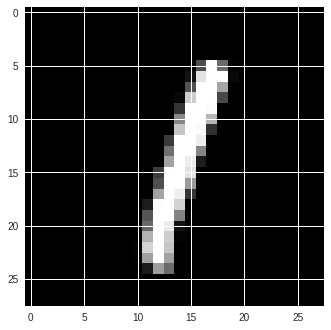

label: 1
predicted_label: 1


In [0]:
import matplotlib.pyplot as plt

model = MLP()
serializers.load_npz('mnist_result/model_epoch-10', model)

# Show the output
x, t = test[5]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

y = model(x[None, ...])

print('predicted_label:', y.array.argmax(axis=1)[0])

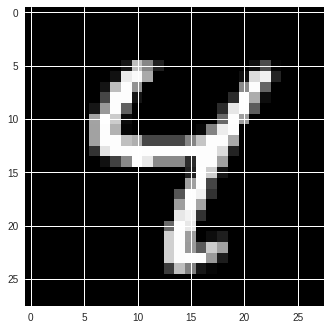

label: 4
predicted_label: 4


In [0]:
import matplotlib.pyplot as plt

model = MLP()
serializers.load_npz('mnist_result/model_epoch-10', model)

# Show the output
x, t = test[6]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

y = model(x[None, ...])

print('predicted_label:', y.array.argmax(axis=1)[0])